# ARIMAX

## DAILY

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from mlflow.models import infer_signature

warnings.filterwarnings("ignore")

In [20]:
df = pd.read_csv('daily_occupancy.csv')
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.set_index('fecha').sort_index()

# Variable objetivo
y = df['ocupacion']

# Variables exógenas
# X = df.drop(columns=['ocupacion'])
exog_cols = ['dia_festivo', 'lag_1', 'lag_2', 'lag_4']
X = df[exog_cols]

# Revisión rápida
print(X.head())
print(y.head())

            dia_festivo   lag_1   lag_2   lag_4
fecha                                          
2019-02-13            0     0.0     0.0     0.0
2019-02-14            0  1006.0     0.0     0.0
2019-02-15            0  1121.0  1006.0     0.0
2019-02-16            0  1249.0  1121.0     0.0
2019-02-17            0  1251.0  1249.0  1006.0
fecha
2019-02-13    1006
2019-02-14    1121
2019-02-15    1249
2019-02-16    1251
2019-02-17     912
Name: ocupacion, dtype: int64


In [21]:
# Split train/test para y y X
horizonte = 30
y_train = y.iloc[:-horizonte]
y_test = y.iloc[-horizonte:]
X_train = X.iloc[:-horizonte]
X_test = X.iloc[-horizonte:]

print(y_train.shape, X_train.shape)
print(y_test.shape, X_test.shape)

(365,) (365, 4)
(30,) (30, 4)


In [22]:
order = (1, 0, 2) # p, d, q

# Ajustar el modelo ARIMAX
modelo_exog = SARIMAX(
    y_train,
    exog=X_train,
    order=order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
modelo_exog_fit = modelo_exog.fit(disp=False)

print(modelo_exog_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              ocupacion   No. Observations:                  365
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -2483.824
Date:                Wed, 21 May 2025   AIC                           4981.648
Time:                        22:56:58   BIC                           5008.890
Sample:                    02-13-2019   HQIC                          4992.478
                         - 02-12-2020                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
dia_festivo   -95.0902     81.639     -1.165      0.244    -255.101      64.920
lag_1           0.9774      0.090     10.836      0.000       0.801       1.154
lag_2          -0.0856      0.104     -0.822    

MAE: 112.23
MPE: 11.72%
RMSE: 147.50


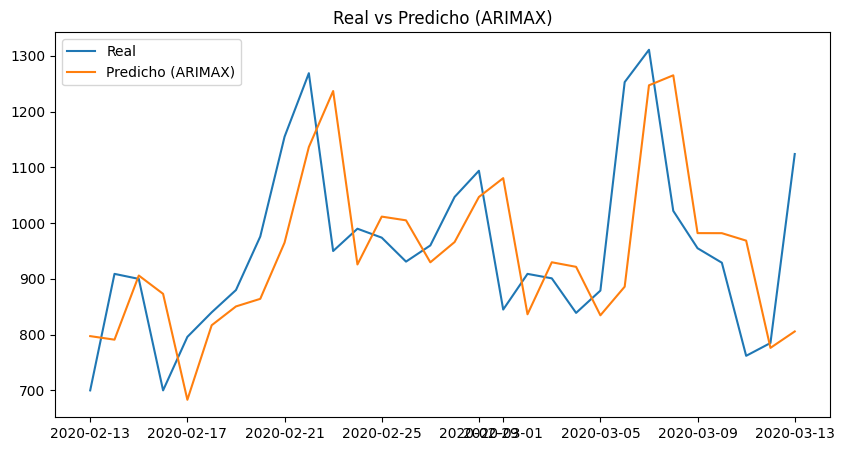

In [23]:
# Predecir los próximos 30 días
predicciones_exog = modelo_exog_fit.forecast(steps=horizonte, exog=X_test)
predicciones_exog.index = y_test.index  # Para que los índices coincidan

# Cálculo de métricas
mae = mean_absolute_error(y_test, predicciones_exog)
mpe = ((y_test - predicciones_exog) / y_test).abs().mean() * 100
rmse = root_mean_squared_error(y_test, predicciones_exog)

print(f"MAE: {mae:.2f}")
print(f"MPE: {mpe:.2f}%")
print(f"RMSE: {rmse:.2f}")

# Gráfica de comparación

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Real')
plt.plot(predicciones_exog, label='Predicho (ARIMAX)')
plt.title('Real vs Predicho (ARIMAX)')
plt.legend()
plt.savefig('arimax_forecast.png', bbox_inches='tight', dpi=300)
plt.show()

In [24]:
# Set tracking URI and experiment
import mlflow.statsmodels


mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("Oumaji_Occupancy")

# Log params, metrics, insights.
# Infer signature
signature = infer_signature(X_train, modelo_exog_fit.forecast(steps=horizonte, exog=X_test))

# Log with MLflow
with mlflow.start_run():    
    # Parametros del modelo
    mlflow.log_param("order", order)
    mlflow.log_param("horizonte", horizonte)
    mlflow.log_param("exog_cols", exog_cols)
    mlflow.log_param("enforce_stationarity", False)
    mlflow.log_param("enforce_invertibility", False)

    # Métricas
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MPE", mpe)
    mlflow.log_metric("RMSE", rmse)

    # Artifactos
    mlflow.log_artifact("arimax_forecast.png", artifact_path="plots")

    # registrar modelo
    mlflow.statsmodels.log_model(modelo_exog_fit, "model", 
                                registered_model_name="ARIMAX", 
                                signature=signature)

2025/05/21 22:56:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'ARIMAX' already exists. Creating a new version of this model...
2025/05/21 22:56:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ARIMAX, version 4


🏃 View run monumental-fox-56 at: http://localhost:5001/#/experiments/176230793224478268/runs/451781f670ae469fbfd7a1c14a0e69fc
🧪 View experiment at: http://localhost:5001/#/experiments/176230793224478268


Created version '4' of model 'ARIMAX'.
